```{contents}
```
## Cyclic Graph

A **cyclic graph** in LangGraph is a **stateful execution graph that contains one or more loops**, allowing nodes to execute repeatedly until a stopping condition is satisfied.
This enables **reasoning–action loops, reflection, self-correction, multi-step planning, and autonomous behavior**—capabilities essential for real-world LLM systems.

---

### **1. Why Cyclic Graphs Exist**

LLM systems rarely solve tasks in a single pass.
They require **iteration**:

| Requirement          | Why                                      |
| -------------------- | ---------------------------------------- |
| Multi-step reasoning | Problems are decomposed gradually        |
| Tool feedback        | Results modify next decision             |
| Error correction     | Model improves after checking            |
| Planning             | Plans evolve over time                   |
| Autonomy             | Systems must continue until goal reached |

LangGraph models this explicitly using **cycles in the execution graph**.

---

### **2. Conceptual Model**

```
        ┌───────────┐
        │  Reason   │
        └─────┬─────┘
              ↓
        ┌───────────┐
        │   Act     │
        └─────┬─────┘
              ↓
        ┌───────────┐
        │  Observe  │
        └─────┬─────┘
              ↓
           (Loop)
```

The loop continues until the **termination condition** becomes true.

---

### **3. How Cycles Are Defined in LangGraph**

A cycle is created by **connecting a later node back to an earlier node** using an edge.

```python
builder.add_edge("observe", "reason")   # creates a loop
```

This transforms the graph into a **finite-state machine with feedback**.

---

### **4. State-Driven Loop Control**

LangGraph does **not** rely on `while` loops.
Instead, **state transitions** determine continuation.

```python
class State(TypedDict):
    step: int
    done: bool
    answer: str
```

Each node updates the shared state.
A **router** decides whether to continue.

```python
def should_continue(state):
    if state["done"]:
        return END
    return "reason"
```

```python
builder.add_conditional_edges("observe", should_continue, {
    "reason": "reason",
    END: END
})
```

---

### **5. Minimal Working Example**



{'count': 5}


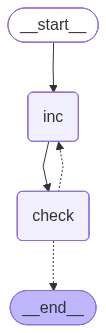

In [15]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    count: int

def increment(state):
    return {"count": state["count"] + 1}

def check(state):
    if state["count"] >= 5:
        return {"done": True}
    return {"done": False}

builder = StateGraph(State)

builder.add_node("inc", increment)
builder.add_node("check", check)

builder.set_entry_point("inc")
builder.add_edge("inc", "check")

builder.add_conditional_edges("check", lambda s: END if s["done"] else "inc", {
    "inc": "inc",
    END: END
})

graph = builder.compile()
print(graph.invoke({"count": 0}))
from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())



**Execution Trace**

```
0 → 1 → 2 → 3 → 4 → 5 → stop
```

---

### **6. Common Cyclic Patterns**

| Pattern          | Purpose                                  |
| ---------------- | ---------------------------------------- |
| ReAct Loop       | Reason → Act → Observe                   |
| Reflection Loop  | Draft → Critique → Revise                |
| Planner-Executor | Plan → Execute → Replan                  |
| Self-Healing     | Detect → Fix → Verify                    |
| Autonomous Agent | Goal → Plan → Execute → Monitor → Repeat |

---

### **7. Safety & Production Controls**

| Mechanism       | Function               |
| --------------- | ---------------------- |
| Max steps       | Prevent infinite loops |
| Timeout         | Prevent hangs          |
| Checkpointing   | Resume safely          |
| Human interrupt | Manual override        |
| Audit log       | Full traceability      |

```python
graph.invoke(input, config={"recursion_limit": 20})
```

---

### **8. Why Cycles Are Critical for Agents**

Without cycles, LLM workflows are **static pipelines**.
With cycles, they become **autonomous reasoning systems**.

| Without Cycles   | With Cycles        |
| ---------------- | ------------------ |
| Single-pass      | Multi-step         |
| No learning      | Self-improving     |
| Fragile          | Robust             |
| Manual workflows | Autonomous systems |

---

### **9. Mental Model**

LangGraph cyclic graphs behave like **control systems**:

> **State → Decision → Action → Feedback → State**

This makes LangGraph suitable for **agents, planners, adaptive systems, and long-running processes**.

---

If you want next, I can explain:

• ReAct loop in LangGraph
• Reflection and self-correction cycles
• How LangGraph prevents infinite loops
• Designing safe autonomous agents
